<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install statsmodels --upgrade

     |████████████████████████████████| 9.5 MB 7.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd

In [4]:
filename = '/content/drive/Shared drives/CMPE295B/JoinedPGEBulbData/2021-08-26_13_2021-09-26_22_hourly.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [5]:
bulb_data.head()

,index,timestamp,brightness,kelvin,kWH,cost,usage,percent_usage_by_bulb,cost_per_bulb
0,0,2021-08-26 13:00:00,1.0,2700.0,0.0085,0.09,0.35,2.428571,0.002186
1,1,2021-08-26 14:00:00,1.0,2700.0,0.0085,0.11,0.38,2.236842,0.002461
2,2,2021-08-26 15:00:00,1.0,2700.0,0.0085,0.09,0.34,2.500000,0.002250
3,3,2021-08-26 16:00:00,1.0,2700.0,0.0085,0.08,0.29,2.931034,0.002345
4,4,2021-08-26 17:00:00,1.0,2700.0,0.0085,0.11,0.40,2.125000,0.002338


### Visualize time series data

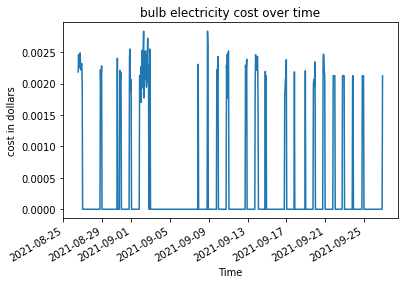

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(bulb_data['timestamp'], bulb_data['cost_per_bulb'])
plt.gcf().autofmt_xdate()
plt.title('bulb electricity cost over time')
plt.ylabel('cost in dollars')
plt.xlabel('Time')
plt.show()

### View autocorrelation plot
- How correlated are current timesteps to previous ones

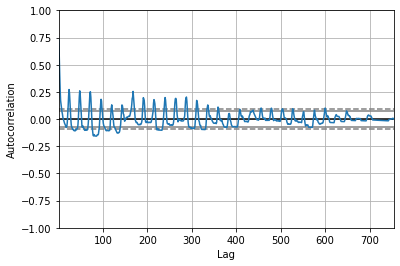

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(bulb_data[['cost_per_bulb']])
plt.show()

- Looks like there is not a lot of correlation between timesteps?
- Confidence interval = 95% so focus on correlations within this interval as they are likely not statistical flukes


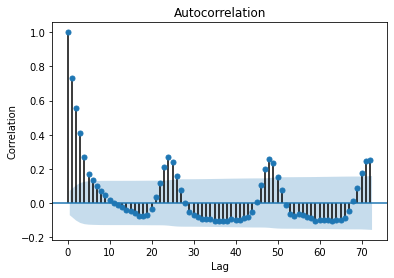

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bulb_data[['cost_per_bulb']], lags=72)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### View partial autocorrelation
- Removes indirect relationships between lags

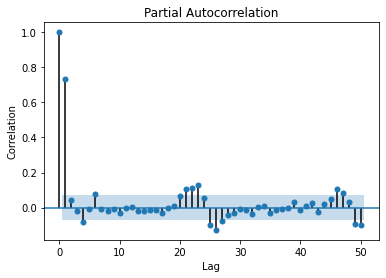

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(bulb_data[['cost_per_bulb']], lags=50)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### Summary
- ACF correlation should be strong for the first k lags then taper off
- PACF should have *no* correlation after k
- Want data to be stationary - remove any trends beforehand analysis
- Ex correlation plots: https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm

In [10]:
def split_train_test(bulb_data, split):
  arima_df = bulb_data[['timestamp', 'cost_per_bulb']]
  arima_df.set_index('timestamp', drop=True, inplace=True)
  values = arima_df.values
  size = int(len(values) * split)
  train, test = values[0:size], values[size:len(values)]
  return (train, test)

In [11]:
train, test = split_train_test(bulb_data[['timestamp', 'cost_per_bulb']], 0.8)
print (len(train), len(test))

603 151


In [12]:
from statsmodels.tsa.arima.model import ARIMA
def fit_model(train):
  model = ARIMA(train, order=(10, 1, 0))
  model_fit = model.fit()

  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  residuals.plot(kind='kde')

  return model_fit

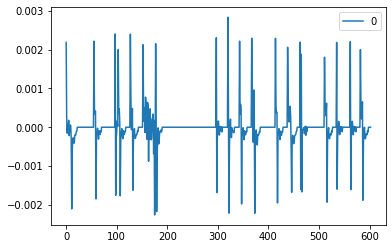

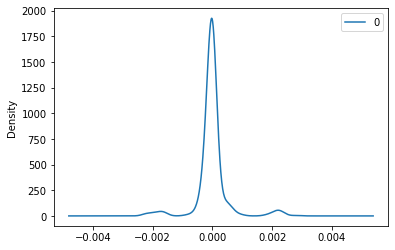

In [13]:
model_fit = fit_model(train)

In [14]:
def rolling_predictions(train, test, order=(10, 1, 0)):
  # put training points in a list
  history = [x for x in train]
  # for storing predictions
  predictions = list()

  # walk-forward validation
  for t in range(len(test)):
    # fit new model each iteration based on all past data points
    model = ARIMA(history, order=order)
    model_fit = model.fit()

    # get the next datapoint and add it to predictions
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test[t])
    print('predicted=%f, expected=%f' % (output[0], test[t]))

  return predictions

In [ ]:
predictions = rolling_predictions(train, test)

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
rmse

0.0005643358134739019

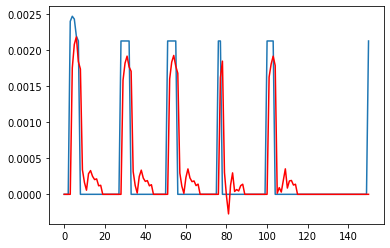

In [23]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()